# Visualising High-Dimensional Data

<br/>
_A brief demo of how and why to use **t-SNE** for feature reduction and plotting._


<div style=float:right><img src="assets/img/tsne_scatterplot.png" width=460 style="margin: 20px 20px"></img></div>

  
**Jonathan Sedar**
+ Consulting Data Scientist
+ Applied AI Ltd
+ <a href="https:/twitter.com/jonsedar">@jonsedar</a>
+ <a href='http://www.applied.ai'>applied.ai</a>

<div style=float:left><img src="assets/img/applied-logo_100px.png"></img></div>


#### Applied AI Internal Demo Project
## HighDim DataViz Demo


<br/>
Demo of high dimensional data visualisation with t-distributed Stochastic Neighbor Embedding (t-SNE) 

+ Using the [Urban Land Cover Classification](https://archive.ics.uci.edu/ml/datasets/Urban+Land+Cover) dataset from the UCI Machine Learning Repository.

+ This content is available on our blog at <a href="http://blog.applied.ai/visualising-high-dimensional-data/">http://blog.applied.ai/visualising-high-dimensional-data/</a>


The **motivation** is to:
1. find and prepare a suitable high-dimensional dataset
2. demonstrate why the raw data can be hard to visually interpret
3. explain the basics of t-SNE
4. run t-SNE to reduce the dataset to 2 dimensions 
5. plot and interpret


Note: this presentation is made using [RISE](https://github.com/damianavila/RISE), an in-development project to display a live Jupyter Notebook in reveal.js presentation form.

_Let me know if you notice anything buggy._

# Contents

+ [Data Description](#Data-Description)
    + [View class group sizes](#View-class-group-sizes) 
    + [View distributions of feature values](#View-distributions-of-feature-values)


+ [Feature Reduction](#Feature-Reduction)
    + [Check for degeneracy and compressability](#Check-for-degeneracy-and-compressability)
    + [Reduce using Truncated SVD](#Reduce-using-Truncated-SVD])
 
    
+ [Basic Visualisation of Reduced Features](#Basic-Visualisation-of-Reduced-Features)
    + [Pairs Plots](#Pairs-Plots)
    + [3D Scatterplot](#3d-Scatterplot)
    
    
+ [t-SNE Visualisation](#t-SNE-Visualisation)
    + [Basic theory](#Basic-theory)
    + [Compare scaling: ordinary vs Barnes Hut](#Compare scaling: ordinary vs Barnes Hut)
    + [Fit and plot t-SNE](#Fit-and-plot-t-SNE)
    + [View t-SNE plot with class labels](#View-t-SNE-plot-with-class-labels)
    
    
+ [Summary](#Summary)
    

##### Abbreviated Contents

+ [Data Description](#Data-Description)  
+ [Feature Reduction](#Feature-Reduction)  
+ [Basic Visualisation of Reduced Features](#Basic-Visualisation-of-Reduced-Features)


+ [t-SNE Visualisation](#t-SNE-Visualisation)
    + [Basic theory](#Basic-theory)
    + [Compare scaling: ordinary vs Barnes Hut](#Compare scaling: ordinary vs Barnes Hut)
    + [Fit and plot t-SNE](#Fit-and-plot-t-SNE)
    + [View t-SNE plot with class labels](#View-t-SNE-plot-with-class-labels)
    

# Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%qtconsole --colors=linux

In [2]:
from collections import OrderedDict, defaultdict
from time import time
import sqlite3

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD

from sklearn.manifold import TSNE
from IPython.html.widgets import interactive, fixed

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 6
np.random.seed(0)

In [3]:
cnx = sqlite3.connect('data/land_cover.db')

## Local Functions

In [4]:
def plot_3d_scatter(A, elevation=30, azimuth=120, max_pts=1000):
    """ Create 3D scatterplot """
    
    fig = plt.figure(1, figsize=(8, 8))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(max_pts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['class'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=60, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

## Load Data

#### Get the two available files and join back together

In [5]:
dforigtrain = pd.read_csv('data/training.csv')
dforigtrain.rename(columns=lambda x: '_'.join([x.strip() for x in x.lower().split()]), inplace=True)
dforigtrain['orig_set'] = 'train'
print(dforigtrain.shape)
dforigtrain.head()

(168, 149)


,class,brdindx,area,round,bright,compact,shpindx,mean_g,mean_r,mean_nir,...,lw_140,glcm1_140,rect_140,glcm2_140,dens_140,assym_140,ndvi_140,bordlngth_140,glcm3_140,orig_set
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36,train
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14,train
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04,train
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38,train
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38,train


In [6]:
dforigtest = pd.read_csv('data/testing.csv')
dforigtest.rename(columns=lambda x: '_'.join([x.strip() for x in x.lower().split()]), inplace=True)
dforigtest['orig_set'] = 'test'
print(dforigtest.shape)
dforigtest.head()

(507, 149)


,class,brdindx,area,round,bright,compact,shpindx,mean_g,mean_r,mean_nir,...,lw_140,glcm1_140,rect_140,glcm2_140,dens_140,assym_140,ndvi_140,bordlngth_140,glcm3_140,orig_set
0,concrete,1.32,131,0.81,222.74,1.66,2.18,192.94,235.11,240.15,...,5.04,0.80,0.58,8.56,0.82,0.98,-0.10,1512,1287.52,test
1,shadow,1.59,864,0.94,47.56,1.41,1.87,36.82,48.78,57.09,...,3.70,0.52,0.96,7.01,1.69,0.86,-0.14,196,2659.74,test
2,shadow,1.41,409,1.00,51.38,1.37,1.53,41.72,51.96,60.48,...,3.09,0.90,0.63,8.32,1.38,0.84,0.10,1198,720.38,test
3,tree,2.58,187,1.91,70.08,3.41,3.11,93.13,55.20,61.92,...,6.33,0.89,0.70,8.56,1.10,0.96,0.20,524,891.36,test
4,asphalt,2.60,116,2.05,89.57,3.06,3.02,73.17,94.89,100.64,...,1.01,0.83,0.75,8.62,2.08,0.08,-0.10,496,1194.76,test


#### Concatenate back together and save to db

In [7]:
dfraw = pd.concat((dforigtrain,dforigtest), axis=0)
dfraw.shape

(675, 149)

In [8]:
# Remove the `orig_set` identifier - we may use it later
df = dfraw[[c for c in dfraw.columns.values.tolist() if c != 'orig_set']]
print(df.shape)

(675, 148)


In [9]:
df.to_sql('df_clean',cnx,if_exists='replace', index=None)

---

# Data Description


Using the [Urban Land Cover Classification](https://archive.ics.uci.edu/ml/datasets/Urban+Land+Cover) dataset from the UCI Machine Learning Repository.

#### We're dealing with Aerial / Satellite imagery

<div><img src="assets/img/aligningLandsat.png" width=1000 style="margin: 20px 20px"></img></div>


#### Combined with ground-truth classifications and subdivided into chunks of land

<div><img src="assets/img/map_roiA_predictLCRawLAPCA.png" width=1000 style="margin: 20px 20px"></img></div>


Our dataset comprises 675 chunks of land, each described by 148 features (the following 21 basic features, each repeated at 7 physical scales):

Size and shape features

    brdindx:    Border Index    (shape) 
    area:       Area in m2      (size) 
    round:      Roundness       (shape) 
    compact:    Compactness     (shape) 
    shpIndx:    Shape Index     (shape) 
    
    lw:         Length/Width    (shape) 
    rect:       Rectangularity  (shape) 
    dens:       Density         (shape) 
    assym:      Assymetry       (shape)
    bordlngth:  Border Length   (shape)      

Spectral and texture features

    bright:   Brightness            (spectral) 
    mean_G:   Green                 (spectral) 
    mean_R:   Red                   (spectral) 
    mean_NIR: Near Infrared         (spectral) 
    ndvi:     Nrmlzd Diff. Veg. Idx (spectral) 

    sd_g:     Std dev of Green      (texture) 
    sd_r:     Std dev of Red        (texture) 
    sd_nir:   Std dev of Near IR    (texture) 
    glcm1:    Gray-Level Co-occurrence Mx (texture) 
    glcm2:    Gray-Level Co-occurrence Mx (texture)  
    glcm3:    Gray-Level Co-occurrence Mx (texture) 

And of course, the land classification

    class: Land Class (id)

### Load from DB and take a look

In [10]:
df = pd.read_sql('select * from df_clean', cnx)
print(df.shape)
df.head()

(675, 148)


,class,brdindx,area,round,bright,compact,shpindx,mean_g,mean_r,mean_nir,...,sd_nir_140,lw_140,glcm1_140,rect_140,glcm2_140,dens_140,assym_140,ndvi_140,bordlngth_140,glcm3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38


## Initial Views: Group Sizes & Distributions

After import we should take a very quick look at the basic group sizes and distributions

### Class group sizes

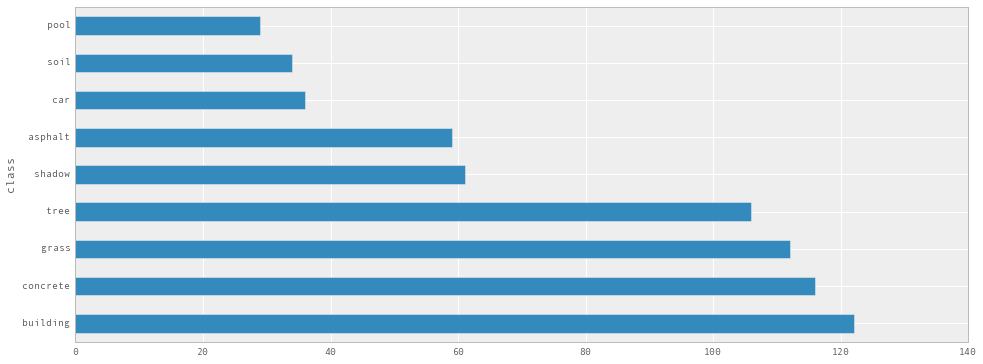

In [11]:
ax = df.groupby('class').size().order()[::-1].plot(
    kind='barh', figsize=(16,6))

+ Most of our 675 land chunks are `building`, `concrete`, `grass` or `tree`
+ The under-represented classes are `car`, `soil` & `pool`

### 1-Dimensional Distributions

In [12]:
grps = ['40','60','80','100','120','140']
basic = ['brdindx','area','round','bright','compact','shpindx'
         ,'mean_g','mean_r','mean_nir','sd_g','sd_r','sd_nir'
         ,'lw','glcm1','rect','glcm2','dens','assym','ndvi','bordlngth','glcm3']

idxdict = OrderedDict()
for b in basic:
    idxdict[b] = [b] + ['{}_{}'.format(b,g) for g in grps]
    
    
def plot_raw_vals(df, k='ndvi'):
    v = idxdict[k]
    dfg = pd.concat((df[['class']],df[v]), axis=1)
    ax = dfg.boxplot(by='class', layout=(2,4), figsize=(14,8)
                    ,showfliers=False, showmeans=True, rot=90)

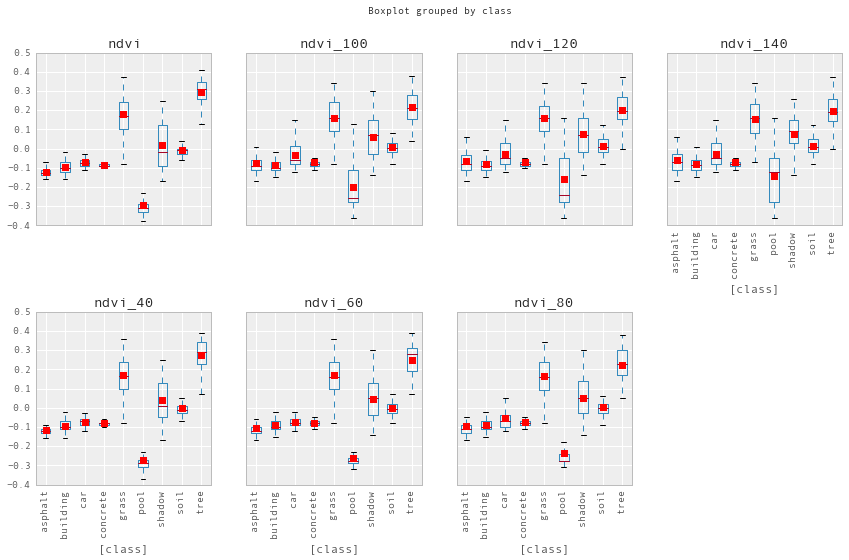

In [13]:
interactive(plot_raw_vals, df=fixed(df), k=basic)

# Feature Reduction

## Check for degeneracy and compressability (scipy svd method)

In [14]:
# standardize
scaler = StandardScaler().fit(df.iloc[:,1:])
dfs = pd.DataFrame(scaler.transform(df.iloc[:,1:]), index=df.index, columns=df.columns[1:])

# use scipy truncated SVD from both ends and concat back together
u1, s1, vt1 = svds(dfs, k=int(np.ceil(dfs.shape[1]/2)), which='LM')
u2, s2, vt2 = svds(dfs, k=int(np.floor(dfs.shape[1]/2)), which='SM')
u = np.concatenate((u2,u1), axis=1)[:,::-1]
s = np.concatenate((s2,s1), axis=0)[::-1]
vt = np.concatenate((vt2,vt1), axis=0)[:,::-1]

# Are any eigenvalues NaN or really small?
print('{} SVs are NaN'.format(np.isnan(s).sum()))
print('{} SVs less than 1e-12'.format(len(s[s < 1e-12])))

0 SVs are NaN
0 SVs less than 1e-12


**Observe**: Okay good, we seem so to have no outright degeneracy

## View explained variance

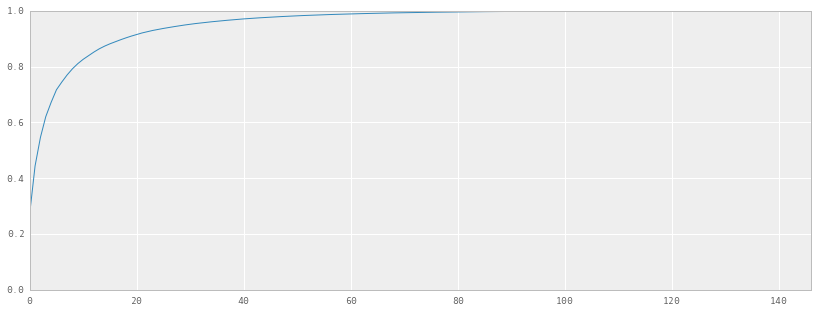

In [15]:
idx = ~np.isnan(s)
xtrans = np.dot(u[:,idx], np.diag(s[idx]))
expvar = np.var(xtrans, axis=0)
fullvar = np.var(dfs, axis=0)
expvarrat = expvar/fullvar.sum()
ax = pd.Series(expvarrat.cumsum()).plot(kind='line', figsize=(14,5)).set_ylim([0,1])

**Observe**: It seems like we can compress the 147 original features into ~80 components (eigenvectors) without loss of variance!

## Feature Reduction (using scikit-learn Truncated-SVD)

We'll use the `TruncatedSVD` method in the `scikit-learn` package to transform the full dataset into a representation using the top 100 components, thus preserving variance in the data but using fewer dimensions to do so. 

This has a very similar effect to [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) where we represent the original data using an orthogonal set of axes rotated and aligned to the variance in the dataset.

Truncated-SVD is a [quicker calculation](https://en.wikipedia.org/wiki/Singular_value_decomposition#Reduced_SVDs), and using `scikit-learn` is more convenient and consistent with our usage elsewhere.

_**Note:**_ there's nothing special about using the top 100 components, it's just a nice round number which preserves a lot of variance and is still too large to easily visualise, necessitating our using t-SNE.

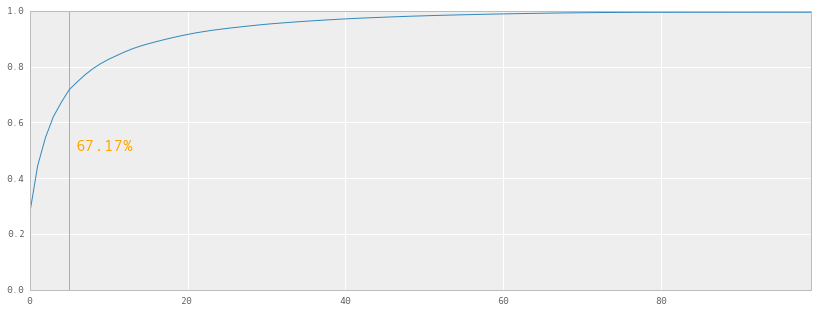

In [16]:
ncomps = 100
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(dfs)
Y = svd.fit_transform(dfs) 
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(
    kind='line', figsize=(14,5))
_ = ax.vlines(5,0,1,'orange')
_ = ax.annotate('{:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[4])
                ,xy=(6,0.5), xycoords='data', color='orange', fontsize=16)

**Observe**: This is quite a compressable dataset, we _could_ choose to retain ~67% variance using only 5 features

In [17]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=df.index)
dfsvd.head()

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
0,7.791615,-5.665540,-5.142433,6.568801,0.475720,3.587330,6.566216,1.328912,-3.042453,-1.700795,...,-0.121772,-0.082097,-0.133029,-0.059098,-0.070651,0.033989,-0.007360,0.180967,-0.043569,0.111030
1,2.402245,5.520586,-1.305692,0.568924,-1.699060,1.912092,-0.956357,1.180367,1.274169,0.002813,...,-0.051219,0.170933,-0.011046,-0.064066,0.014135,-0.032964,0.003311,-0.003710,-0.077524,0.056149
2,6.655337,-1.089973,-1.486441,-0.761643,1.091498,0.549244,-1.511058,-1.215297,1.181897,-1.607650,...,-0.007976,0.013337,0.014519,0.018665,-0.021159,0.016851,-0.011069,0.025478,-0.001896,0.000007
3,6.786879,4.643247,0.469147,-0.637604,0.877795,2.365046,-1.154191,0.027911,1.693199,-1.822488,...,0.012480,0.003630,0.053713,-0.012564,-0.042762,0.044025,-0.010061,0.003222,0.019955,0.019869
4,1.416315,13.627604,5.196395,5.980829,10.790677,-3.430901,-4.159976,3.382595,-0.675996,6.953366,...,-0.008216,0.026812,-0.006590,0.019685,-0.000048,0.014517,0.012588,0.010433,-0.012841,-0.007074


In [18]:
# Write to DB
dfsvd.to_sql('df_svd',cnx,if_exists='replace', index=None)

---

# Basic Visualisation

Now that we have a compressed dataset, represented by the top 100 components of an SVD, lets attempt to visualise the data:

In [19]:
dfsvd = pd.read_sql('select * from df_svd', cnx)
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

df = pd.read_sql('select * from df_clean', cnx)

## Pairs Plots

Using the first few components

In [20]:
dfsvdplot = dfsvd[svdcols].iloc[:,:5]
dfsvdplot['class'] = df['class']

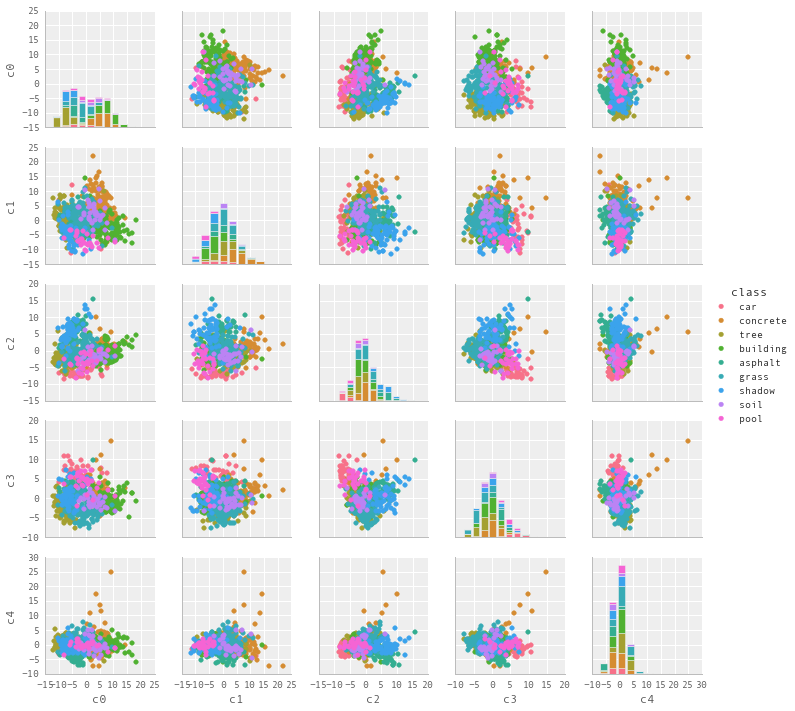

In [21]:
ax = sns.pairplot(dfsvdplot.iloc[::1,:], hue='class', size=2)

##### Observe:

Datapoints from the same land usage classes tend to cluster together

Distinct classes on different sides of the plots, e.g.

+ `building` is far from `tree` along the `c0` component
+ `concrete` is far from `shadow` along the `c1` component

However, this pairs-plot suffers several issues:

+ 5x5 components only shows 67% of full variance
+ Showing more components e.g. 10x10 unworkable
+ Reader must comparisons in their head while viewing
+ Classes with lower counts e.g. `car` and `pool` are hard to see


## 3D Scatterplot

In [22]:
dfsvd['class'] = df['class']

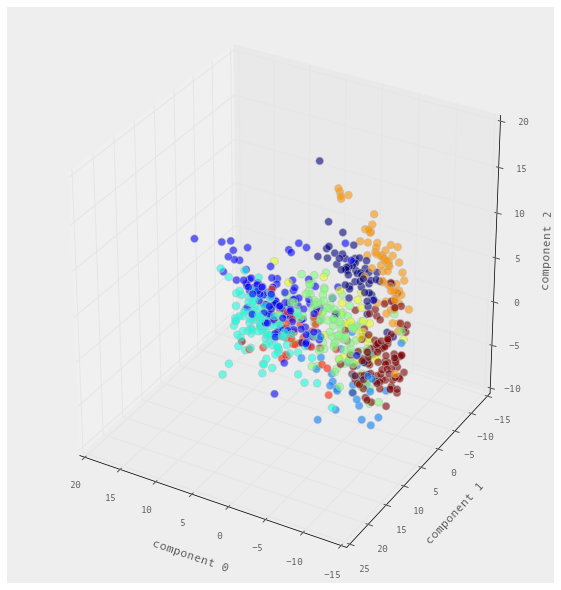

In [23]:
interactive(plot_3d_scatter, A=fixed(dfsvd), elevation=30, azimuth=120, max_pts=fixed(1000))

##### Observe:
+ `ipywidgets` interactive controls for elevation and azimuth
+ Viewing top components in 3D is slightly useful
+ Still suffer from the major limitations of the pairs-plots
+ Lose a lot of the variance 
+ Have to hold a lot in our heads when viewing.

Clearly need a better way to visualise the 675 datapoints and their 100 dimensions


---

**Note**: Normally would also detect and view outliers as part of the discovery process, but in this case we can be more brief since the data is well-understood and clean. Our prop. visualisation method makes use of the MinCovDet.

---

# t-SNE Visualisation

Ready to discuss t-Distributed Stochastic Neighbor Embedding (t-SNE)


+ t-SNE is a probabilistic technique for dimensionality reduction (aka manifold learning) 
+ Primary use is for visualisation 
+ Developed by [Laurens van der Maaten](https://lvdmaaten.github.io/) and [Geoffery Hinton](http://www.cs.toronto.edu/~hinton/) and [first published](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) in 2008 
+ The main resource for theoretical detail (papers, talks etc) is https://lvdmaaten.github.io/tsne/.

## Basic theory


_Create a 'good' 2D repr of data originally described in $d$ dimensions._


**First:** Build a probabilistic repr. of the full dimensional manifold:

+ Measure pairwise affinity (euclidian distance) between all datapoints $X = \{x_{1}, x_{2}, x_{n}\}$ in full $d$ dimensions 
+ Record affinities as cond. probs. $p_{j|i}$ using a **Gaussian kernel** 
    + i.e. the prob. of $x_{i}$ having $x_{j}$ as it's nearest neighbor
+ For close neighbors, $p_{j|i}$ is higher than for distant ones
+ Combine all probs. into a joint prob. dist. $P = \sum_{i}\sum_{j}p_{j|i}$


**Second** Build a probabilistic repr of a 2D manifold:

+ Use PCA to represent datapoints using top 2 components
+ Measure pairwise affinity (euclidian distance) between all datapoints $Y = \{y_{1}, y_{2}, y_{n}\}$ in 2D 
+ Record distances as cond. probs. $q_{j|i}$ etc using a **Student t-Distributed kernel**
    + i.e. the prob. of $y_{i}$ having $y_{j}$ as it's nearest neighbor
+ Combine all probs into a joint prob. dist. $Q = \sum_{i}\sum_{j}q_{j|i}$


If $Y$ were a perfect map of $X$, then $P \approx Q$


...unlikely if $d >> 2$

So we minimise the distance between $P$ and $Q$:

+ Measure the cost function of KL-Divergence $C= KL(P||Q)$ 
+ Use stochastic gradient descent to minimise $C$, aka peturb the distribution of $Y$ (and therefore $Q$) until $C$ converges

More detail:

+ KL is non-symmetric: $C$ is lower for distant points in $X$, so it preserves locality
+ Tuneable (variance of Gaussian kernel, perplexity, momentum, noise variance, learning rate)
+ Additional tricks: early compression (L2-penalty on $C$), early exaggeration (force $p_{ij}$ too large)

The result is a 2D representation that quite accurately preserves local distances, so grouping in $d$ becomes apparent


Alternatives include Isomap, Multi-Dimensional Scaling, Locally Linear Embedding (all of which available in [scikit-learn](http://scikit-learn.org/stable/modules/manifold.html)) and [Topological Data Analysis](http://www.dyinglovegrape.com/math/topology_data_1.php).


## Compare scaling: ordinary vs Barnes Hut

We will use and compare the two implementations available in `scikit-learn`: 

+ ordinary t-SNE, which has $O(d \space n^{2})$ complexity, (1000's points)
+ Barnes-Hut approximated t-SNE, which runs in $O(d \space n \space log(n))$ (1,000,000's points)


In [24]:
rowsubset = [10,20,40,80,160,320,640]
tsne = TSNE(n_components=2, random_state=0, method='exact')
tsnebh = TSNE(n_components=2, random_state=0, method='barnes_hut')

runs = np.empty((2, len(rowsubset), 10))

for k, mdl in enumerate([tsne, tsnebh]):
    for j, nrows in enumerate(rowsubset):
        for i in range(10):
            t0 = time()
            Z = mdl.fit_transform(dfsvd.iloc[:nrows,:][svdcols])
            runs[k,j,i] = time() - t0


In [25]:
dfruns = pd.DataFrame({'duration':runs.ravel()
                       ,'model': ['exact']*10*7 + ['barnes_hut']*10*7
                       ,'nrows': np.array([[r]*10 for r in rowsubset] * 2).ravel()})

In [26]:
# g = sns.boxplot(x='nrows', y='duration', hue='model', data=dfruns, vert=False)
# g = sns.barplot(y='nrows', x='duration', hue='model', data=dfruns, orient='h')
# g.invert_yaxis()

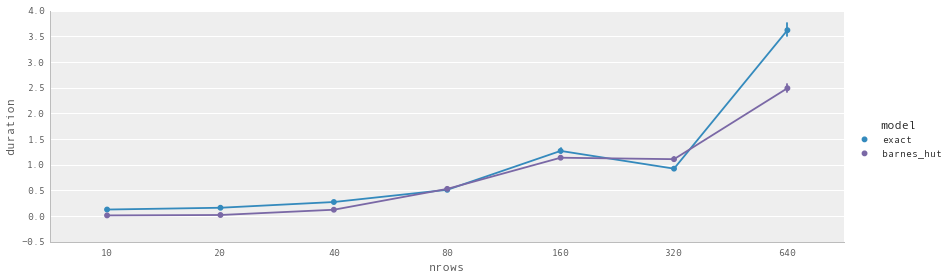

In [27]:
g = sns.factorplot(x='nrows', y='duration', hue='model', data=dfruns, aspect=3)

**Observe**:
+ Imperfect test
+ We can see Barnes-Hut starting to offer speed advantage

## Fit and plot t-SNE

In [28]:
%timeit Z = tsne.fit_transform(dfsvd[svdcols])

Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

1 loops, best of 3: 3.98 s per loop


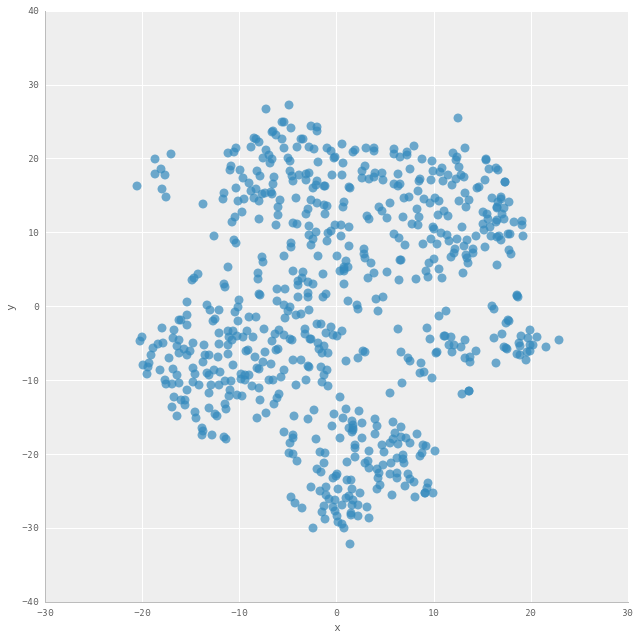

In [29]:
ax = sns.lmplot('x', 'y', dftsne, fit_reg=False, size=9, scatter_kws={'alpha':0.7,'s':80})

##### Observe:
+ This is promising... top 100 SVD components -> 2 dimensions and we can clearly see clusters of datapoints.

When doing unsupervised learning (without class labels) we might expect to get this far and then backtrack to run clustering algorithms in the 100 dimensional space.

Now let's view the t-SNE representation with land classification class labels...

# View t-SNE plot with class labels

In [30]:
dftsne['class'] = df['class']

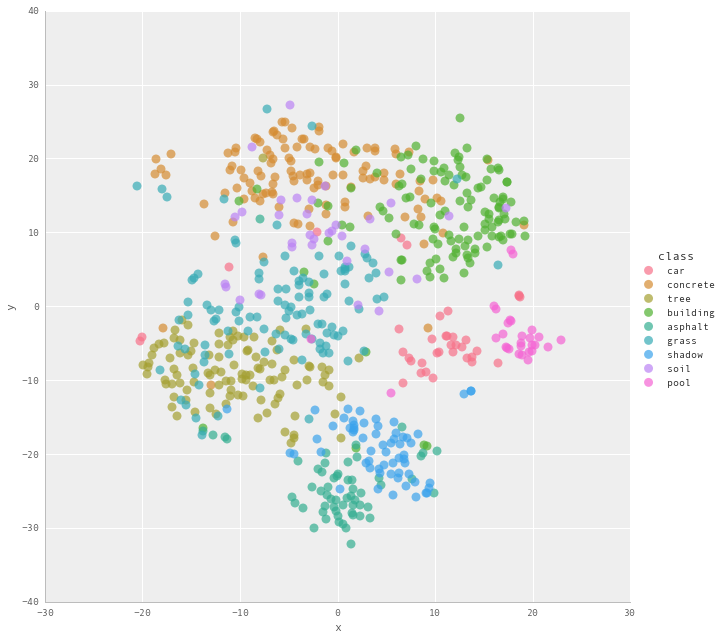

In [31]:
g = sns.lmplot('x', 'y', dftsne, hue='class', fit_reg=False, size=9, scatter_kws={'alpha':0.7,'s':80})

##### Observe
With class labels added we can clearly see the clustering of land classes

+ Again we see `building` as a very distinct cluster from `tree` 
+ but now also as distinct from `asphalt`, `shadow`, `grass`, `car` and `pool`

Now we can start to see similarities in classes, e.g.

+ `shadow` and `asphalt` (dark on the images?)
+ `car` and `pool` (high reflectance and small area?)
+ `tree` and `grass` (vegetation with similar red & IR absorption?)
    

The great thing about the t-SNE representation is that is preserves local structure present at high dimensions, meaning that neighboring points also appear close in the low dimensional representation. Clusters of similar classes are obvious and intuitive.

# Summary

We have sourced and prepared a small but high-dimensional dataset:

+ Difficulty of visualising the raw data
+ Benefits of using feature reduction (degeneracy / redundancy)
+ Difficulty of visualising even the prepared data in 2D & 3D

We have demonstrated using t-SNE to:
+ Create a low-dim representation of the high-dim data
+ Visualise the structure with class clusters easily seen.

# Thank You

<div style=float:right><img src="assets/img/applied-logo.png" width=400 style="margin: 20px 20px"></img></div>

**Jonathan Sedar**
+ Consulting Data Scientist
+ Applied AI Ltd
+ <a href="https:/twitter.com/jonsedar">@jonsedar</a>
+ <a href='http://www.applied.ai'>applied.ai</a>


This content is available on our blog at http://blog.applied.ai/visualising-high-dimensional-data/